# 02. Modeling

![Model](./Assets/model.png)

In this notebook, I will be making a _Machine Learning **Neural Network** Model_ to classify between the image as `With Mask` and `Without Mask` 
![mask, without mask](./Assets/mask_no_mask.png)

### For this Model as it is a classification problem, we will be aiming for accuracy of >95% 

In [1]:
# Standard Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# importing function to split the data
from sklearn.model_selection import train_test_split

In [3]:
# Imports for preprocessing the data
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

In [4]:
# Imports for making of the Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Dropout, Flatten
from keras.optimizers import Adam

Defining the constants

In [5]:
TEST_RATIO = 0.20
VAL_RATIO = 0.20 # Validation ratio
IMAGE_SIZE = 96 # Image size 32 x 32 px
# Model constants
BATCH_SIZE = 32
EPOCHS = 60
MODEL_PATH = './Data/mask_detection_model.model'  # the path where model will be saved
INIT_LR = 1e-4


### Loading the data

In [6]:
images = np.load('./Data/images.npy')
classes = np.load('./Data/target.npy')

number_of_classes = len(np.unique(classes)) # Getting the total number of unique classes

len(images), len(classes), number_of_classes

(4024, 4024, 2)

### Spliting the data into train, test and validation set

`X` are the features and `y` is the target

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=TEST_RATIO)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VAL_RATIO)

# checking the shapes of the data
print(f"Train set -> X: {X_train.shape}, y: {y_train.shape}")
print(f"Test set -> X: {X_test.shape}, y: {y_test.shape}")
print(f"Validation set -> X: {X_validation.shape}, y: {y_validation.shape}")

Train set -> X: (2575, 96, 96, 3), y: (2575,)
Test set -> X: (805, 96, 96, 3), y: (805,)
Validation set -> X: (644, 96, 96, 3), y: (644,)


### Before we make the model, we should:
- Reshape the sets to the needed shape
- Increase the contrast of the image for better results using [cv2.equalizeHist()](https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html)
- Convert the integer values to float values between 0 and 1
- And also make sure they all are also grey for good results
- The target array should be categorical 

In [8]:
# defining a function to preprocess the images
def img_preprocessing(image):
    """Takes an image and returns the preprocesses version of it."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = cv2.equalizeHist(image)  # Increasing the contrast of the image
    
    image = image / 255  # converting the image to float
    
    return image

In [9]:
# Preprocessing the Images
X_train = np.array(list(map(img_preprocessing, X_train)))
X_test = np.array(list(map(img_preprocessing, X_test)))
X_validation = np.array(list(map(img_preprocessing, X_validation)))

# Reshaping the sets
# the new shape should be (*previous_shape, 1), i.e. it should be array first element of a new array 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)

In [10]:
# turning the y sets (target sets) into categorical arays
# using a built in function in keras for one-hot-encoding the sets
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)
y_validation = to_categorical(y_validation, number_of_classes)

In [11]:
# using Image data augmentation 
# Image data argumentation is a technique that can be used to artificially expand the size of a 
# training dataset by creating modified versions of images in the dataset 

# creating the ImageDataGenerator object
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

In [12]:
# generation and fiting the train images
data_gen.fit(X_train)

## Making the ML Model to classify between Mask and No-Mask images

In [13]:
size_of_filter = (3, 3)
size_of_pool = (2, 2)

# Making the layers
model = Sequential()
model.add((Conv2D(32, size_of_filter, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), activation='relu')))
model.add((Conv2D(32, size_of_filter, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool))

model.add((Conv2D(64, size_of_filter, activation='relu')))
model.add((Conv2D(64, size_of_filter, activation='relu')))
model.add(MaxPooling2D(pool_size=size_of_pool))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_of_classes, activation='softmax'))
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0

#### Fitting the data into the Model

In [14]:
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (X_validation, y_validation),
    shuffle = 1
)

Epoch 1/60
80/80 [==============================] - 58s 718ms/step - loss: 0.6204 - accuracy: 0.6113 - val_loss: 0.1308 - val_accuracy: 0.9689
Epoch 2/60
80/80 [==============================] - 57s 707ms/step - loss: 0.2484 - accuracy: 0.9108 - val_loss: 0.0731 - val_accuracy: 0.9736
Epoch 3/60
80/80 [==============================] - 55s 687ms/step - loss: 0.1964 - accuracy: 0.9224 - val_loss: 0.0700 - val_accuracy: 0.9767
Epoch 4/60
80/80 [==============================] - 55s 687ms/step - loss: 0.1658 - accuracy: 0.9394 - val_loss: 0.1016 - val_accuracy: 0.9627
Epoch 5/60
80/80 [==============================] - 55s 686ms/step - loss: 0.1778 - accuracy: 0.9379 - val_loss: 0.0673 - val_accuracy: 0.9767
Epoch 6/60
80/80 [==============================] - 59s 736ms/step - loss: 0.1570 - accuracy: 0.9370 - val_loss: 0.0584 - val_accuracy: 0.9845
Epoch 7/60
80/80 [==============================] - 59s 733ms/step - loss: 0.1287 - accuracy: 0.9536 - val_loss: 0.0643 - val_accuracy: 0.9736

### Plotting the training loss and accuracy of the model

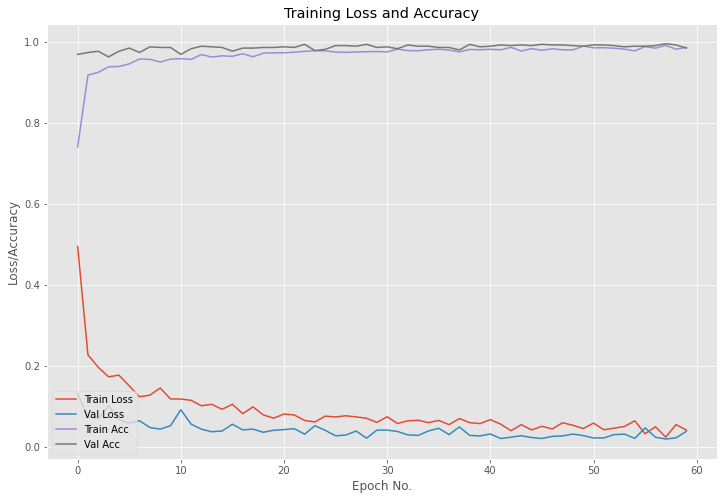

In [15]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 8))

x_axis = np.arange(0, EPOCHS)

ax.plot(x_axis, history.history['loss'], label="Train Loss")
ax.plot(x_axis, history.history['val_loss'], label="Val Loss")
ax.plot(x_axis, history.history['accuracy'], label="Train Acc")
ax.plot(x_axis, history.history['val_accuracy'], label="Val Acc")

ax.set(
    title = "Training Loss and Accuracy",
    xlabel = "Epoch No.",
    ylabel = "Loss/Accuracy"
)

ax.legend(loc="lower left")

plt.show()

## Evaluating the Model

In [16]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 5s 194ms/step - loss: 0.0139 - accuracy: 0.9950


[0.013913455419242382, 0.9950310587882996]

## Saving the model

In [17]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ./Data/mask_detection_model.model\assets


# The model looks good with idk accuracy, so lets go to the next step